# Google drive mounting

In [116]:
# Mount Drive
import os
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Data

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [118]:
distances = pd.read_csv("/content/drive/My Drive/RouteRunners/Large-Scale-Route-Optimization/distance.csv")

# Graph Class

In [119]:
class Graph:
    def __init__(self, directed=True):
        self.adjacency_list = {}
        self.directed = directed

    def add_Node(self, node):
        if node not in self.adjacency_list:
            self.adjacency_list[node] = []

    def add_Edge(self, node1, node2, weight):
        self.add_Node(node1)
        self.add_Node(node2)
        self.adjacency_list[node1].append((node2, weight))
        if not self.directed:
            self.adjacency_list[node2].append((node1, weight))

    def get_Neighbors(self, node):
        return self.adjacency_list.get(node, [])


# Graph Generator Class

In [120]:
class GraphGenerator:
    def __init__(self, distances_df):
        self.distances_df = distances_df

    def create_random_graph(self, num_edges=500, exclude_edge=None, directed=False):
        if exclude_edge:
            node1, node2 = exclude_edge
            mask1 = ~((self.distances_df['Source'] == node1) & (self.distances_df['Destination'] == node2))
            mask2 = ~((self.distances_df['Source'] == node2) & (self.distances_df['Destination'] == node1))
            filtered_df = self.distances_df[mask1 & mask2]
        else:
            filtered_df = self.distances_df

        sampled_edges = filtered_df.sample(n=num_edges)
        adjacency_list = {}

        for _, row in sampled_edges.iterrows():
            src, dst, dist = row['Source'], row['Destination'], row['Distance(M)']
            if directed:
                adjacency_list.setdefault(src, []).append((dst, dist))
            else:
                adjacency_list.setdefault(src, []).append((dst, dist))
                adjacency_list.setdefault(dst, []).append((src, dist))

        return adjacency_list

    def generate_random_graphs_and_paths(self, start, goal, num_graphs=100, num_edges_per_graph=300, exclude_direct_edge=False, directed=False):
        paths = []
        for _ in range(num_graphs):
            exclude = (start, goal) if exclude_direct_edge else None
            graph = self.create_random_graph(num_edges=num_edges_per_graph, exclude_edge=exclude, directed=directed)
            finder = AStarPathFinder()
            _, path = finder.run_a_star(graph, start, goal)
            paths.append(path if path else None)
        return paths


# Djiksta Pathfinder Class

In [121]:
class DijkstraPathFinder:
    def run_dijkstra(self, graph, start, goal):
        """
        Implements Dijkstra's algorithm to find the shortest path from start to goal.
        Assumes graph is a dictionary where keys are node names and values are lists of (neighbor, weight) tuples.

        Parameters:
            graph (dict): A dictionary where keys are nodes and values are lists of (neighbor, weight) tuples.
            start (str): The starting node.
            goal (str): The goal node.

        Returns:
            tuple: A tuple (distances, path), where:
                - distances (dict): A dictionary with the shortest distance to each node.
                - path (list): The shortest path from start to goal.
        """
        # Initialize the nodes, distances, and previous nodes dictionaries
        nodes = graph.keys()
        unvisited = set(nodes)

        if goal not in nodes:  # If goal is not in graph, return empty path immediately
            return {}, []

        distances = {node: float('inf') for node in nodes}
        distances[start] = 0
        previous_nodes = {node: None for node in nodes}

        while unvisited:
            # Find the node with the smallest distance
            current_node = min(
                (node for node in unvisited), key=lambda node: distances[node]
            )
            unvisited.remove(current_node)

            # If we've reached the goal, stop the search
            if current_node == goal:
                break

            # Check all neighbors of the current node
            for neighbor, weight in graph.get(current_node, []):
                if neighbor not in graph:  # Skip if the neighbor is not in the graph
                    continue
                alt_distance = distances[current_node] + weight
                if alt_distance < distances[neighbor]:
                    distances[neighbor] = alt_distance
                    previous_nodes[neighbor] = current_node

        # If the goal node is unreachable, return an empty path
        if distances[goal] == float('inf'):
            return distances, []  # No path found, return empty path

        # Reconstruct the shortest path from the goal to the start
        path = []
        current_node = goal
        while current_node is not None:
            path.append(current_node)
            current_node = previous_nodes[current_node]
        path.reverse()

        return distances, path

# A Star Class

In [122]:
class AStarPathFinder:
    def heuristic(self, node1, node2, coordinates=None):
        if coordinates and node1 in coordinates and node2 in coordinates:
            x1, y1 = coordinates[node1]
            x2, y2 = coordinates[node2]
            return ((x1 - x2)**2 + (y1 - y2)**2)**0.5
        else:
            return 0

    def run_a_star(self, graph, start, goal, coordinates=None):
        from heapq import heappush, heappop

        all_nodes = set(graph.keys())
        for edges in graph.values():
            for neighbor, _ in edges:
                all_nodes.add(neighbor)

        g_score = {node: float('inf') for node in all_nodes}
        g_score[start] = 0
        f_score = {node: float('inf') for node in all_nodes}
        f_score[start] = self.heuristic(start, goal, coordinates)

        open_set = []
        heappush(open_set, (f_score[start], start))
        came_from = {}

        while open_set:
            _, current = heappop(open_set)

            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                path.reverse()
                return f_score, path

            for neighbor, weight in graph.get(current, []):
                tentative_g_score = g_score[current] + weight
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, goal, coordinates)
                    heappush(open_set, (f_score[neighbor], neighbor))

        return f_score, []


# RouteRunner Class

In [123]:
class RouteRunners:
    def __init__(self, paths):
        self.paths = paths

    def count_failed_paths(self):
        return sum(1 for path in self.paths if path is None)

    def count_edge_usage(self):
        """
        Count the usage of each edge across all paths.
        Only considers valid paths (ignores None values).
        """
        edge_counts = {}
        for path in self.paths:
            if path:  # Ensure the path is not None
                for i in range(len(path) - 1):
                    edge = (path[i], path[i + 1])
                    edge_counts[edge] = edge_counts.get(edge, 0) + 1
        return edge_counts

    def display_edge_usage_table(self, edge_counts, top_n=10):
        """
        Display the edge usage as a table of the top N most used edges.
        """
        if edge_counts:
            edge_df = pd.DataFrame(list(edge_counts.items()), columns=["Edge", "Usage"])
            edge_df = edge_df.sort_values("Usage", ascending=False)
            print(edge_df.head(top_n))
        else:
            print("No edge counts to display.")

    def compare_algorithms(self, graph, start, goal):
        """
        Compare Dijkstra and A* on the given graph and print the results.
        """
        dijkstra = DijkstraPathFinder()
        astar = AStarPathFinder()

        dj_distances, dj_path = dijkstra.run_dijkstra(graph, start, goal)
        astar_distances, astar_path = astar.run_a_star(graph, start, goal)

        print("=== Dijkstra ===")
        print(f"Path: {dj_path}")
        print(f"Distance: {dj_distances[goal] if dj_path else 'Unreachable'}\n")

        print("=== A* ===")
        print(f"Path: {astar_path}")
        print(f"Distance: {astar_distances[goal] if astar_path else 'Unreachable'}\n")

        if dj_path == astar_path:
            print("Both algorithms produced the same path.")
        else:
            print("Paths differ between Dijkstra and A*.")


# Testing to see if A star and Djikstra's will produce different paths

In [124]:
runner = RouteRunners(paths=[])

for i in range(10):
    graph = GraphGenerator(distances).create_random_graph(num_edges=400, directed=True)
    runner.compare_algorithms(graph, start='City_24', goal='City_47')

=== Dijkstra ===
Path: ['City_24', 'City_43', 'City_47']
Distance: 1574146

=== A* ===
Path: ['City_24', 'City_43', 'City_47']
Distance: 1574146

Both algorithms produced the same path.
=== Dijkstra ===
Path: ['City_24', 'City_45', 'City_44', 'City_47']
Distance: 2095460

=== A* ===
Path: ['City_24', 'City_45', 'City_44', 'City_47']
Distance: 2095460

Both algorithms produced the same path.
=== Dijkstra ===
Path: ['City_24', 'City_11', 'City_30', 'City_38', 'City_47']
Distance: 2357658

=== A* ===
Path: ['City_24', 'City_11', 'City_30', 'City_38', 'City_47']
Distance: 2357658

Both algorithms produced the same path.
=== Dijkstra ===
Path: ['City_24', 'City_28', 'City_47']
Distance: 1154737

=== A* ===
Path: ['City_24', 'City_28', 'City_47']
Distance: 1154737

Both algorithms produced the same path.
=== Dijkstra ===
Path: ['City_24', 'City_15', 'City_47']
Distance: 2142115

=== A* ===
Path: ['City_24', 'City_15', 'City_47']
Distance: 2142115

Both algorithms produced the same path.
=== 

# Creating Paths

In [125]:
generator = GraphGenerator(distances_df=distances)
paths = generator.generate_random_graphs_and_paths(start='City_24', goal='City_47', num_graphs=300)

runner = RouteRunners(paths)
print("Number of Graphs with no path:", runner.count_failed_paths())

edge_usage1 = runner.count_edge_usage()
runner.display_edge_usage_table(edge_usage1, top_n=50)


Number of Graphs with no path: 0
                   Edge  Usage
12   (City_24, City_47)     40
18   (City_33, City_47)     30
35   (City_32, City_47)     27
6    (City_24, City_31)     19
4    (City_24, City_25)     18
62    (City_24, City_1)     18
64   (City_22, City_47)     18
30    (City_24, City_2)     17
13   (City_24, City_28)     16
53   (City_23, City_47)     16
17   (City_24, City_33)     15
37   (City_24, City_23)     15
32   (City_24, City_22)     14
27   (City_42, City_47)     14
21   (City_24, City_29)     14
5    (City_25, City_47)     14
45    (City_24, City_8)     14
34   (City_24, City_32)     13
7    (City_31, City_47)     13
63    (City_1, City_47)     12
72    (City_8, City_47)     12
23   (City_28, City_47)     12
67   (City_24, City_27)     11
19   (City_24, City_39)     11
31    (City_2, City_47)      9
8    (City_24, City_37)      8
20   (City_39, City_47)      8
82   (City_29, City_47)      8
58   (City_24, City_30)      8
59   (City_30, City_47)      7
11   (

In [126]:
generator = GraphGenerator(distances_df=distances)

paths = generator.generate_random_graphs_and_paths(
    start='City_24',
    goal='City_47',
    num_graphs=300,
    directed=True
)
runner = RouteRunners(paths)
print("Number of Graphs with no path:", runner.count_failed_paths())

edge_usage2 = runner.count_edge_usage()
runner.display_edge_usage_table(edge_usage2, top_n=50)

Number of Graphs with no path: 5
                   Edge  Usage
16   (City_24, City_47)     24
56   (City_24, City_30)     19
2     (City_24, City_2)     14
169  (City_33, City_47)     13
58   (City_24, City_31)     13
64    (City_24, City_0)     12
123  (City_46, City_47)     10
106   (City_24, City_1)     10
12   (City_24, City_29)     10
1    (City_45, City_47)      9
83   (City_24, City_33)      9
63    (City_8, City_47)      8
25   (City_38, City_47)      8
209  (City_22, City_47)      8
28   (City_24, City_28)      8
62    (City_24, City_8)      8
108  (City_39, City_47)      8
73   (City_48, City_47)      8
131  (City_24, City_39)      8
129  (City_28, City_47)      8
8    (City_44, City_47)      7
15   (City_42, City_47)      7
229  (City_43, City_47)      7
19    (City_0, City_47)      7
174  (City_31, City_47)      7
119  (City_30, City_47)      7
61   (City_25, City_47)      7
86   (City_32, City_47)      7
185  (City_24, City_49)      6
200  (City_24, City_10)      6
154  (

In [127]:
generator = GraphGenerator(distances_df=distances)

paths = generator.generate_random_graphs_and_paths(
    start='City_24',
    goal='City_47',
    num_graphs=300,
    exclude_direct_edge= True,
    directed=True
)
runner = RouteRunners(paths)
print("Number of Graphs with no path:", runner.count_failed_paths())

edge_usage3 = runner.count_edge_usage()
runner.display_edge_usage_table(edge_usage3, top_n=50)

Number of Graphs with no path: 3
                   Edge  Usage
92   (City_24, City_28)     15
53   (City_24, City_27)     15
25   (City_24, City_30)     14
18   (City_42, City_47)     14
61    (City_2, City_47)     14
201   (City_24, City_2)     14
70   (City_24, City_23)     13
119  (City_45, City_47)     12
56   (City_48, City_47)     12
0    (City_24, City_39)     12
43   (City_24, City_31)     11
252  (City_39, City_47)     11
130   (City_24, City_1)     10
51   (City_61, City_47)     10
124   (City_24, City_0)     10
77   (City_31, City_47)     10
203  (City_33, City_47)      9
135  (City_27, City_47)      9
83    (City_0, City_47)      9
50   (City_24, City_61)      9
112  (City_46, City_47)      9
267  (City_32, City_47)      9
41    (City_24, City_8)      9
143  (City_24, City_33)      9
127  (City_30, City_47)      8
102  (City_10, City_47)      8
57   (City_24, City_29)      8
42    (City_8, City_47)      8
31   (City_24, City_10)      8
149  (City_24, City_34)      8
158  (

In [128]:
generator = GraphGenerator(distances_df=distances)

paths = generator.generate_random_graphs_and_paths(
    start='City_24',
    goal='City_47',
    num_graphs=300,
    exclude_direct_edge=True
)

runner = RouteRunners(paths)
print("Number of Graphs with no path:", runner.count_failed_paths())

edge_usage4 = runner.count_edge_usage()
runner.display_edge_usage_table(edge_usage4, top_n=50)


Number of Graphs with no path: 0
                   Edge  Usage
45   (City_24, City_30)     31
4    (City_24, City_31)     27
20   (City_24, City_28)     26
13   (City_32, City_47)     21
80   (City_33, City_47)     21
15   (City_24, City_23)     20
5    (City_31, City_47)     19
47   (City_30, City_47)     18
18   (City_24, City_29)     17
54    (City_24, City_2)     17
29   (City_24, City_27)     17
62   (City_22, City_47)     16
0     (City_24, City_0)     16
37    (City_8, City_47)     15
17   (City_28, City_47)     14
3    (City_42, City_47)     14
22   (City_27, City_47)     14
31   (City_23, City_47)     14
82   (City_39, City_47)     13
66   (City_25, City_47)     13
42    (City_24, City_1)     13
51    (City_2, City_47)     12
25   (City_24, City_37)     12
8    (City_29, City_47)     12
79   (City_37, City_47)     11
11   (City_24, City_25)     10
35   (City_24, City_22)     10
59   (City_24, City_33)      9
9    (City_24, City_38)      9
6    (City_24, City_39)      8
10   (

# Vizualizer Class

In [129]:
class Visualizer:
    def __init__(self, edge_counts=None, city_counts=None):
        """
        Initialize the Visualizer with edge and/or city counts.

        Parameters:
            edge_counts (dict): Dictionary of edge usage frequencies.
            city_counts (dict): Dictionary of city usage frequencies.
        """
        self.edge_counts = edge_counts
        self.city_counts = city_counts or self.count_city_usage()

    def count_city_usage(self):
        """
        Counts how often each city appears in all edges from shortest paths.

        Returns:
            dict: {city: total frequency across edges}, adjusted to avoid double-counting.
        """
        if not self.edge_counts:
            print("Edge counts are not provided.")
            return {}

        city_counts = {}
        for (city1, city2), count in self.edge_counts.items():
            city_counts[city1] = city_counts.get(city1, 0) + count
            city_counts[city2] = city_counts.get(city2, 0) + count

        # Divide each count by 2 to correct for double-counting
        for city in city_counts:
            city_counts[city] //= 2

        return city_counts


    def plot_edge_usage_heatmap(self):
        """
        Plots a heatmap of edge usage frequencies. Assumes directed edges.
        """
        if not self.edge_counts:
            print("Edge counts are not provided.")
            return

        nodes = sorted({city for edge in self.edge_counts for city in edge})
        usage_matrix = pd.DataFrame(0, index=nodes, columns=nodes)

        for (a, b), count in self.edge_counts.items():
            usage_matrix.loc[a, b] = count

        plt.figure(figsize=(12, 10))
        sns.heatmap(usage_matrix, cmap='Reds', linewidths=0.5)
        plt.title("Edge Usage Heatmap (Shortest Path Frequency)")
        plt.xlabel("Destination Node")
        plt.ylabel("Source Node")
        plt.show()

    def plot_city_usage_heatmap(self, top_n=None):
        """
        Plots a horizontal heatmap (bar chart style) of city usage frequencies,
        excluding the top 2 most-used cities.

        Parameters:
            top_n (int): Show only top-N most-used cities (after removing top 2)
        """
        if not self.city_counts:
            print("City counts are not provided.")
            return

        city_df = pd.DataFrame(list(self.city_counts.items()), columns=["City", "Usage"])
        city_df = city_df.sort_values("Usage", ascending=False).iloc[2:]

        if top_n:
            city_df = city_df.head(top_n)

        plt.figure(figsize=(0.5 * len(city_df), 4))
        sns.heatmap(
            city_df.set_index("City").T,
            cmap="Reds",
            cbar=True,
            linewidths=0.5,
            annot=True,
            fmt='d'
        )
        plt.title("City Usage in Shortest Paths (Excluding Start and End Cities)")
        plt.yticks([])
        plt.show()


    def plot_city_usage_barplot(self, top_n=25):
        """
        Plots a vertical bar plot of city usage frequencies.

        Parameters:
        exclude_top (int): Number of top-most used cities to exclude (default is 2).
        """
        if not self.city_counts:
            print("City counts are not provided.")
            return

        # Convert to DataFrame and sort
        city_df = pd.DataFrame(list(self.city_counts.items()), columns=["City", "Usage"])
        city_df = city_df.sort_values("Usage", ascending=False).iloc[2:]

        # Optionally limit to top N
        if top_n:
            city_df = city_df.head(top_n)

        # Plot
        plt.figure(figsize=(max(6, 0.5 * len(city_df)), 6))
        sns.barplot(x="City", y="Usage", data=city_df, palette="Reds_r")
        plt.title("City Usage Frequency (Bar Plot)")
        plt.xlabel("City")
        plt.ylabel("Usage Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def analyze_path_failures_vs_edges(self, distances_df, start, goal, num_graphs=100, edge_range=range(1, 401), directed=True):
        results = []

        for num_edges in edge_range:
            generator = GraphGenerator(distances_df=distances_df)
            paths = generator.generate_random_graphs_and_paths(
                start=start,
                goal=goal,
                num_graphs=num_graphs,
                num_edges_per_graph=num_edges,
                directed=directed,
                exclude_direct_edge=True
            )
            runner = RouteRunners(paths)
            failed_count = runner.count_failed_paths()
            results.append((num_edges, failed_count))

        df = pd.DataFrame(results, columns=["NumEdges", "NumFailures"])
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df, x="NumEdges", y="NumFailures")
        plt.title(f"Graphs with No Valid Path vs. Number of Edges ({'Directed' if directed else 'Undirected'})")
        plt.xlabel("Number of Edges in Each Graph")
        plt.ylabel("Graphs with No Valid Path")
        plt.grid(True)
        plt.show()


# Plotting Paths

Undirected Graphs with no explicit exclusion

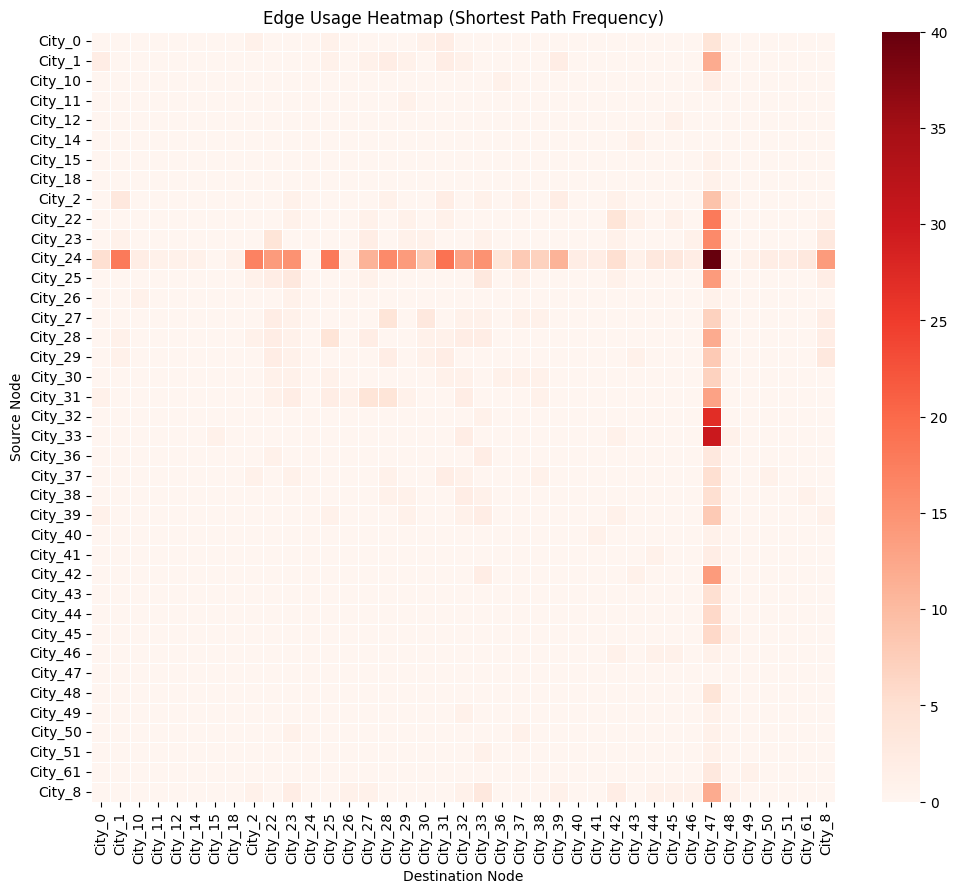

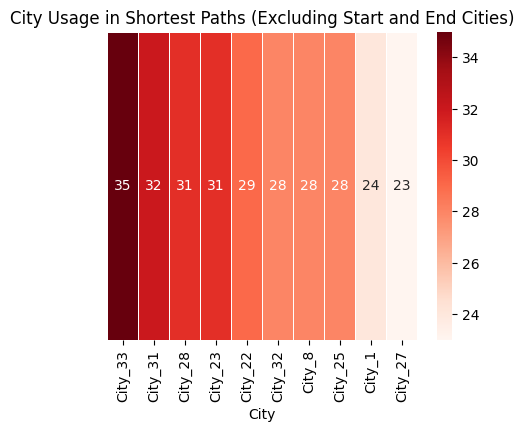

<ipython-input-129-d34b226134ed>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="City", y="Usage", data=city_df, palette="Reds_r")


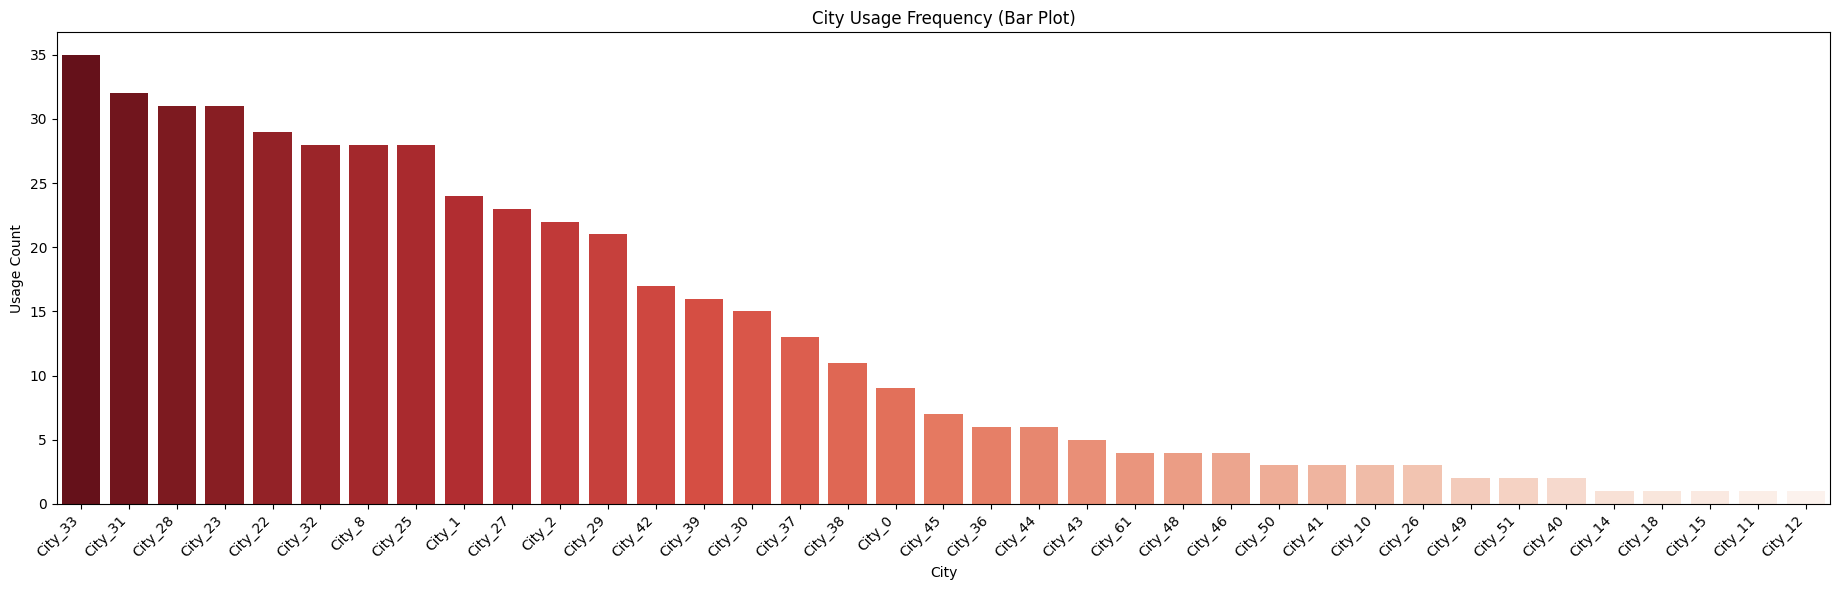

In [130]:
visualizer = Visualizer(edge_counts=edge_usage1)
visualizer.plot_edge_usage_heatmap()
visualizer.plot_city_usage_heatmap(top_n=10)
visualizer.plot_city_usage_barplot(top_n=100)

Directed Graphs with no explicit exclusion

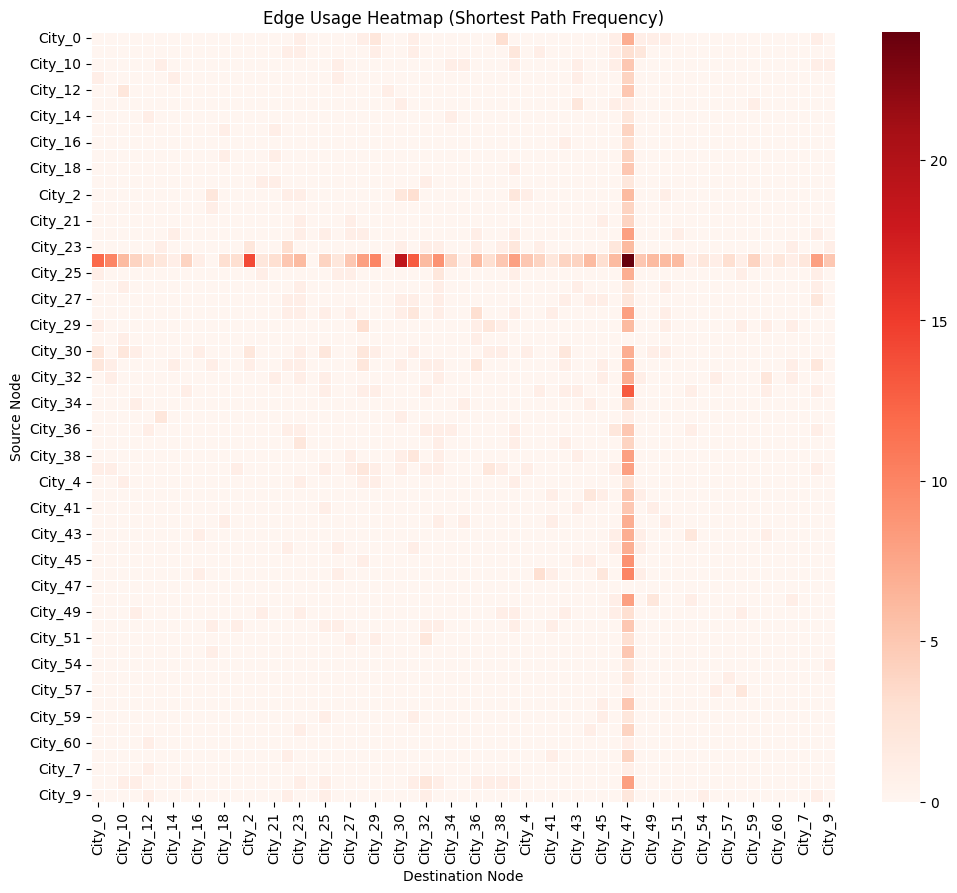

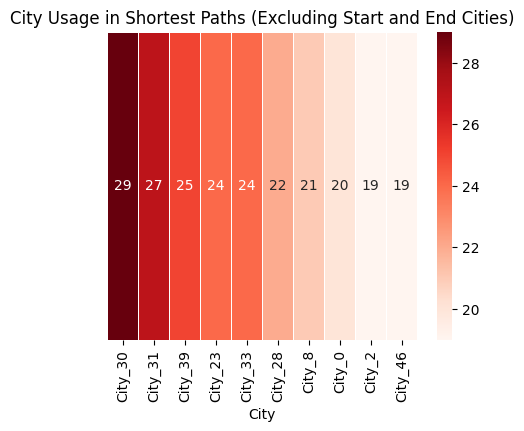

<ipython-input-129-d34b226134ed>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="City", y="Usage", data=city_df, palette="Reds_r")


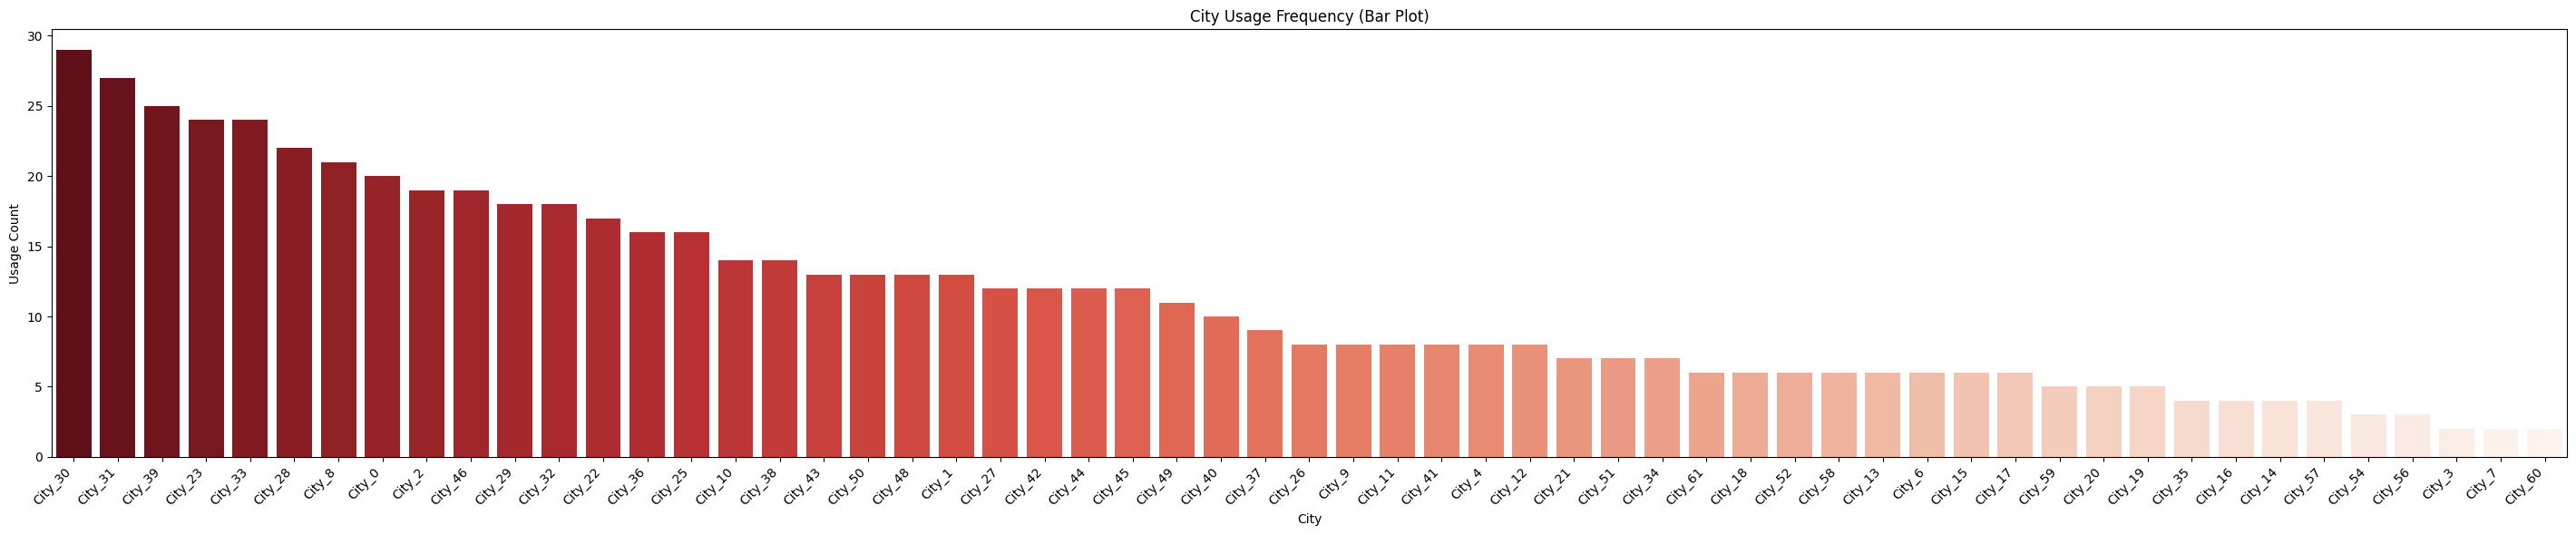

In [131]:
visualizer = Visualizer(edge_counts=edge_usage2)
visualizer.plot_edge_usage_heatmap()
visualizer.plot_city_usage_heatmap(top_n=10)
visualizer.plot_city_usage_barplot(top_n=100)

Directed Graphs with explicit exclusion

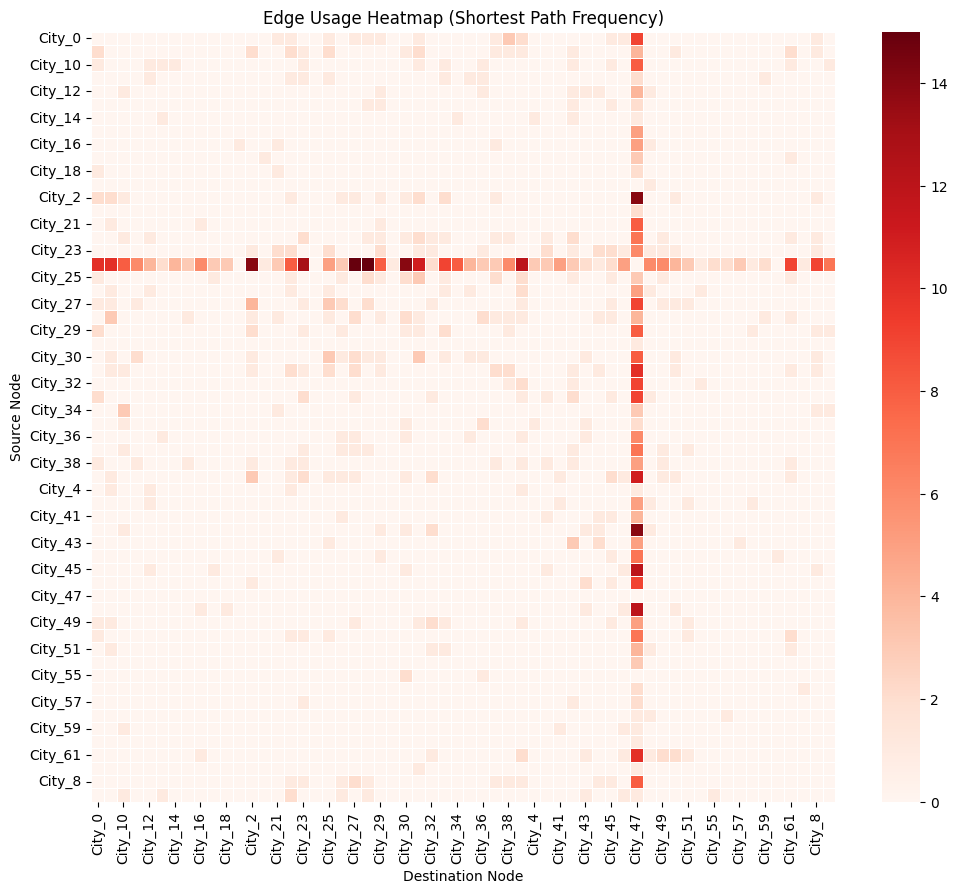

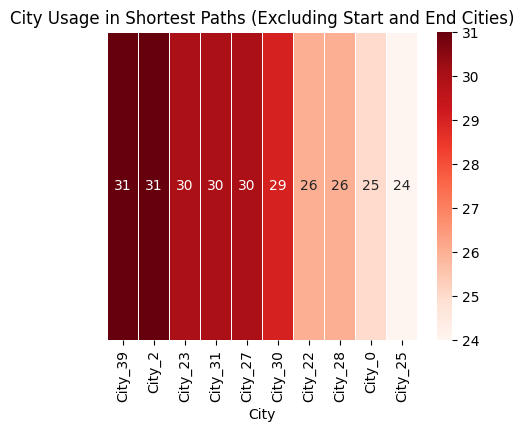

<ipython-input-129-d34b226134ed>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="City", y="Usage", data=city_df, palette="Reds_r")


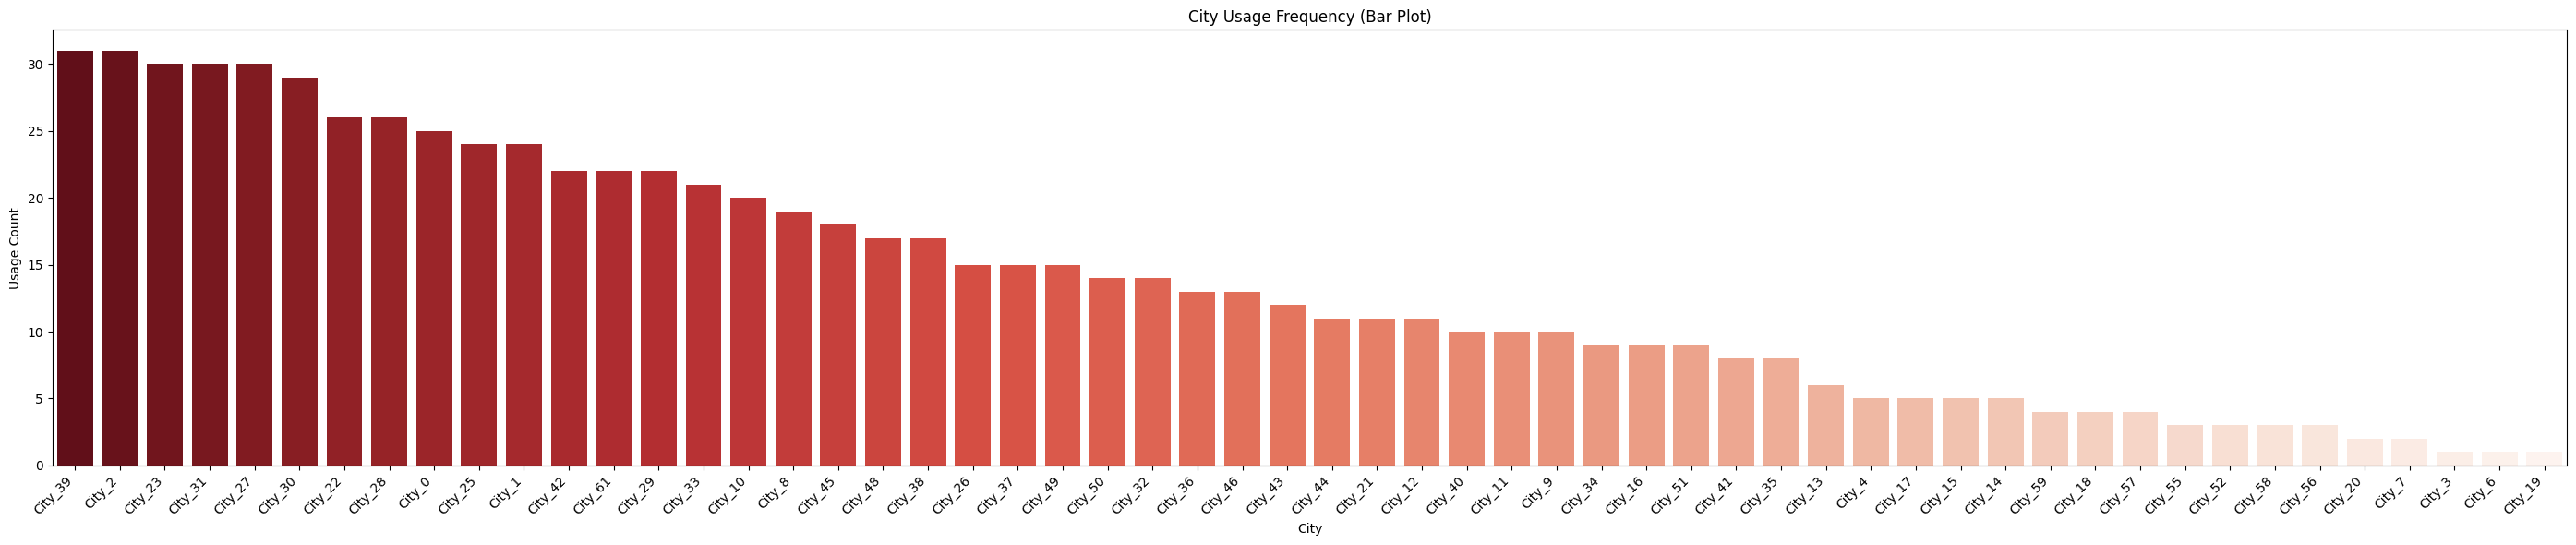

In [132]:
visualizer = Visualizer(edge_counts=edge_usage3)
visualizer.plot_edge_usage_heatmap()
visualizer.plot_city_usage_heatmap(top_n=10)
visualizer.plot_city_usage_barplot(top_n=100)

Undirected Graphs with explicit exclusion

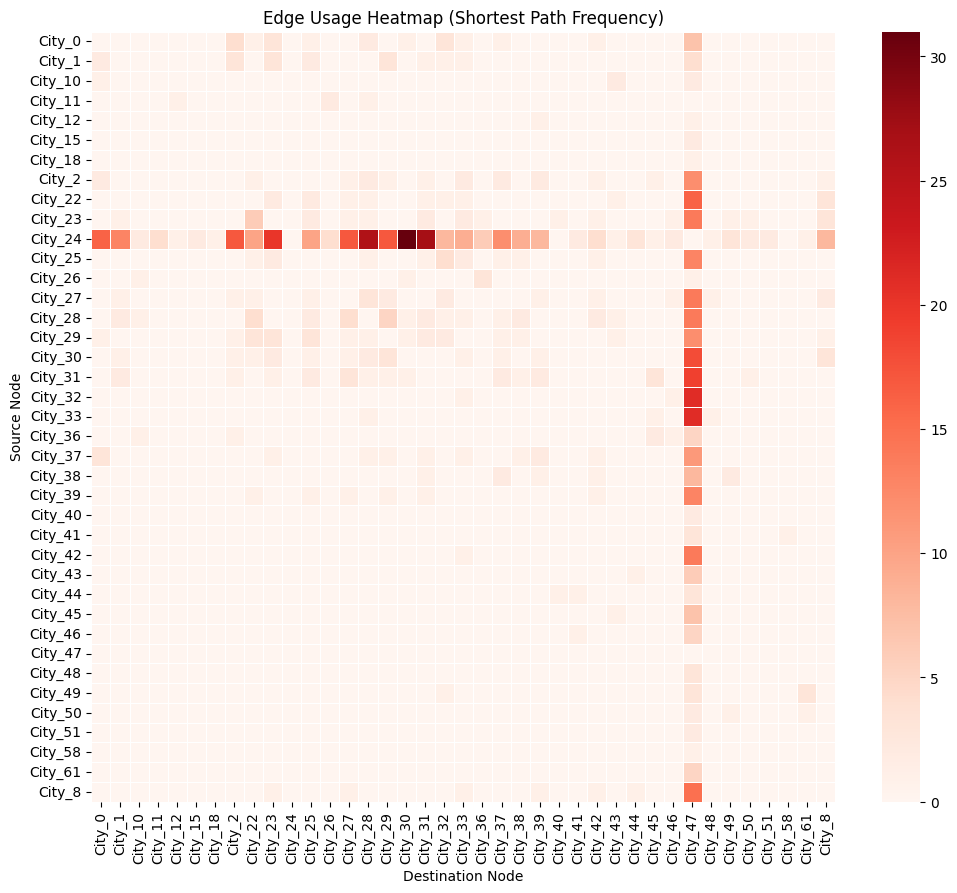

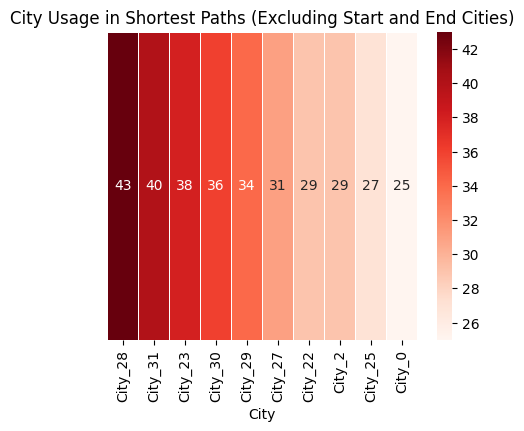

<ipython-input-129-d34b226134ed>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="City", y="Usage", data=city_df, palette="Reds_r")


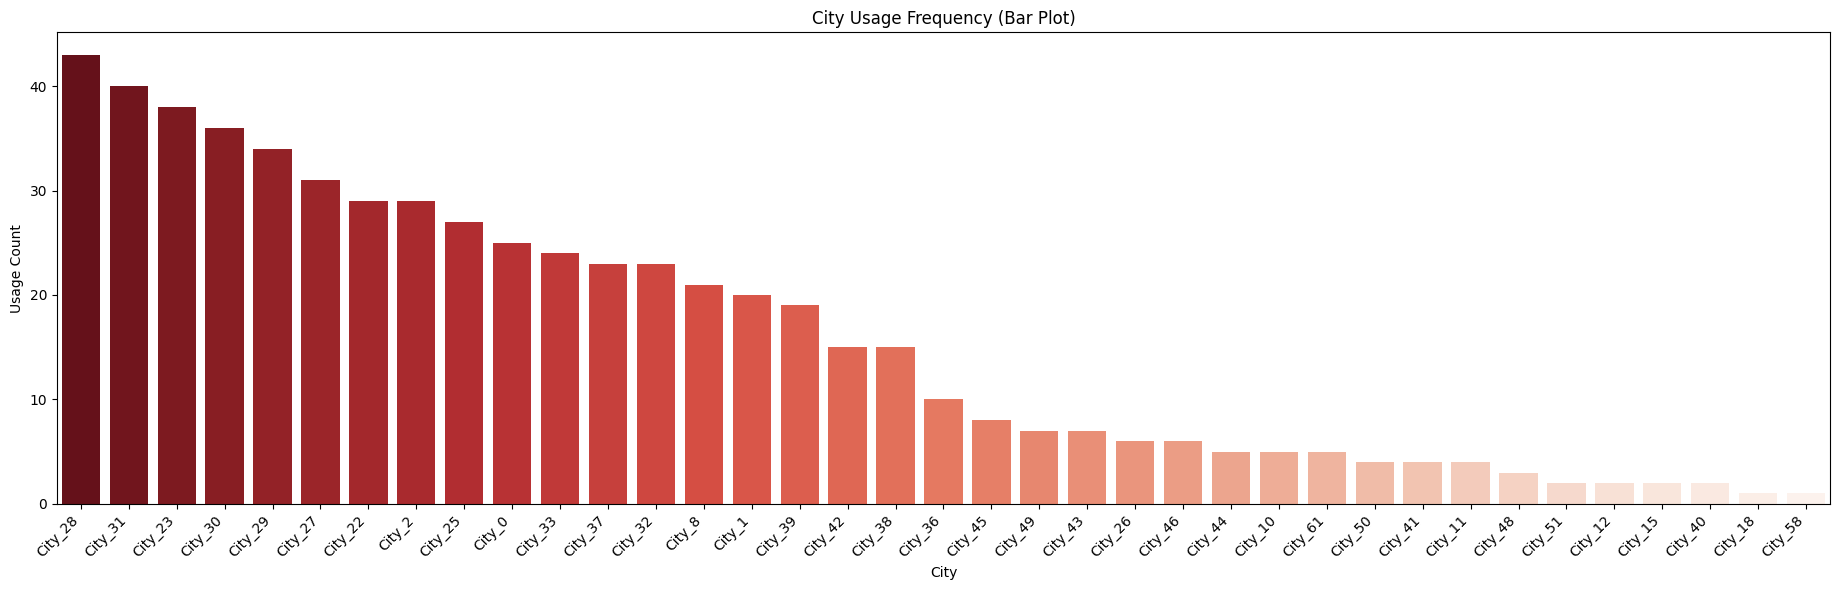

In [133]:
visualizer = Visualizer(edge_counts=edge_usage4)
visualizer.plot_edge_usage_heatmap()
visualizer.plot_city_usage_heatmap(top_n=10)
visualizer.plot_city_usage_barplot(top_n=100)

# Visualizing failed graphs

Edge counts are not provided.


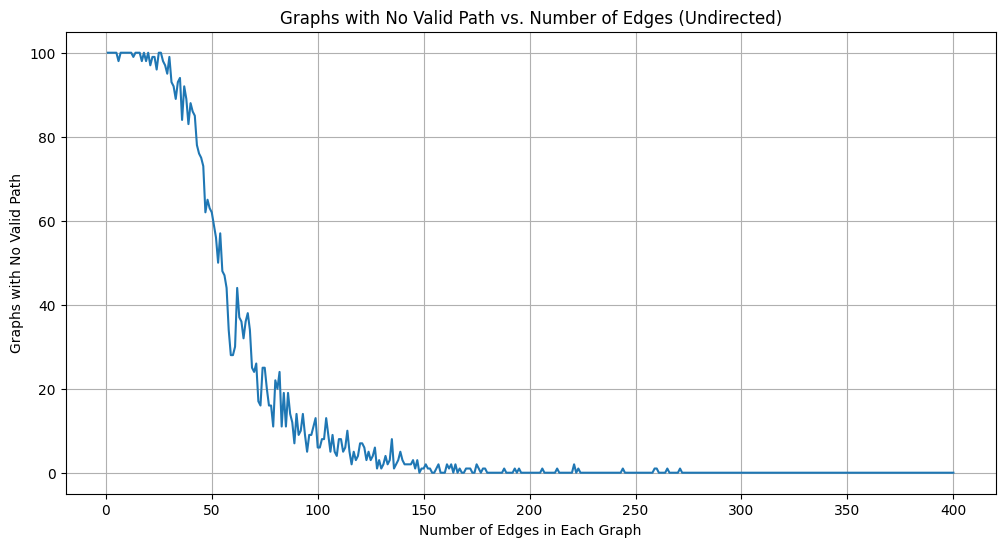

In [134]:
visualizer = Visualizer()
visualizer.analyze_path_failures_vs_edges(distances_df=distances, start='City_24', goal='City_47', directed=False)

Edge counts are not provided.


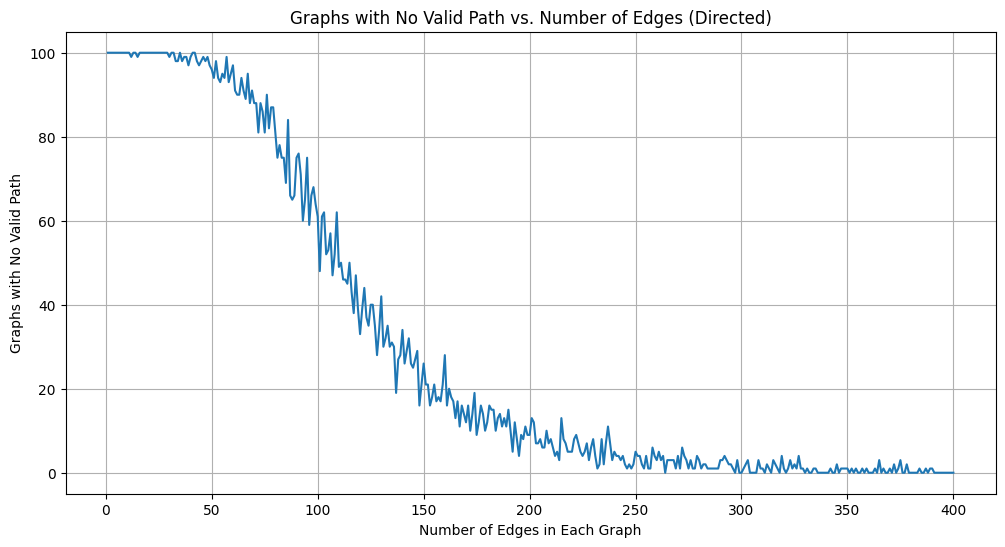

In [135]:
visualizer = Visualizer()
visualizer.analyze_path_failures_vs_edges(distances_df=distances, start='City_24', goal='City_47')